## Estocasticidad

**En esta notebook se repiten**

- Entrenamiento de modelos 
- Sampleos de Censo

Con el objetivo de evaluar la variabilidad por factores aleatorios en resultados de:
    
    - Pobreza

# 1. Entrenamiento de modelos

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd

In [2]:
overwrite = False
startyr = 2019
endyr = 2020

# Column names
y_cols = ['CAT_OCUP', 'P47T', 'PP10E', 'PP10D', 'PP07K', 'PP07I', 'V3_M', 'PP07G4', 'CH16', 'T_VI', 
          'V12_M', 'TOT_P12', 'PP07G3', 'V5_M', 'PP07H', 'V2_M', 'PP10C', 
          'PP08D1', 'PP07J', 'CAT_INAC', 'CH07', 'CH08', 'P21', 'PP07G1', 'PP07G_59', 'PP07G2']

x_cols1 = ['IX_TOT', 'P02', 'P03', 'AGLO_rk', 'Reg_rk', 'V01', 'H05', 'H06',
       'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H16', 'H15', 'PROP', 'H14',
       'H13', 'P07', 'P08', 'P09', 'P10', 'P05', 'CONDACT']

predecir1 = ['CAT_OCUP', 'CAT_INAC', 'CH07']

x_cols2 = x_cols1 + predecir1
predecir2 = ['INGRESO', 'INGRESO_NLB', 'INGRESO_JUB', 'INGRESO_SBS']

x_cols3 = x_cols2 + predecir2
# La seccion PP07G pregunta si el trabajo es en blanco y que beneficios tiene. Puede ayudar a la regresion para ingresos.
# predecir3 = ['PP07G1', 'PP07G2', 'PP07G3', 'PP07G4', 'PP07G_59', 'PP07H', 'PP07I', 'PP07J', 'PP07K']
predecir3 = ['PP07G1','PP07G_59', 'PP07I', 'PP07J', 'PP07K']

# Columnas de ingresos. Necesitan una regresion...
columnas_pesos = [u'P21', u'P47T', u'PP08D1', u'TOT_P12', u'T_VI', u'V12_M', u'V2_M', u'V3_M', u'V5_M']

x_cols4 = x_cols3 + predecir3
# Columnas de ingresos. Necesitan una regresion...
predecir4 = columnas_pesos
y_cols4 = predecir4

In [3]:
### Save models at: (ocupan bastante memoria en disco)
models_path = '/media/miglesia/Elements/suite/estocasticidad_indice_pobreza'

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import os
import joblib

def fit_model(train_data, x_cols, y_cols, out_filename,
             model):
    X = train_data[x_cols]
    y = train_data[y_cols]
    
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.1) # less memory used
    
    clf = model.fit(X.values, y.values)

    # save the model to disk
    if not os.path.exists(models_path + '/fitted_RF/'):
        os.makedirs(models_path + '/fitted_RF/')
    joblib.dump(model, out_filename, compress=3)
    print('saved model at: ' + out_filename)

#     print(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)[:5])
    del clf
    del X; del y # liberar memoria eliminando los dataframes mas pesados

In [5]:
import pandas as pd
from numpy import log10

In [6]:
training_sets_path = './../../encuestador-de-hogares/data/training/'

n_models = 5

for i in range(n_models):
    models_tag = str(i).zfill(3)
    print(models_tag)

    for yr in [str(s) for s in range(startyr, endyr)]:
        print(yr)
        train_data = pd.read_csv(training_sets_path + 'EPHARG_train_'+yr[2:]+'.csv')

        ## ETAPA 1:
        out = models_path + '/fitted_RF/clf1_'+yr+'_'+models_tag
        if (not os.path.exists(out)) or (overwrite):
            fit_model(train_data, x_cols = x_cols1, y_cols = predecir1, out_filename = out,
                     model = RandomForestClassifier(n_estimators=100, max_depth = 20, n_jobs = -1))

        ## ETAPA 2:
        out = models_path + '/fitted_RF/clf2_'+yr+'_'+models_tag
        if (not os.path.exists(out)) or (overwrite):
            fit_model(train_data, x_cols = x_cols2, y_cols = predecir2, out_filename = out,
                     model = RandomForestClassifier(n_estimators=100, max_depth = 20, n_jobs = -1))

        ## ETAPA 3:
        out = models_path + '/fitted_RF/clf3_'+yr+'_'+models_tag
        if (not os.path.exists(out)) or (overwrite):
            fit_model(train_data, x_cols = x_cols3, y_cols = predecir3, out_filename = out,
                     model = RandomForestClassifier(n_estimators=100, max_depth = 20, n_jobs = -1))

        ## ETAPA 4 (Regresion)
        ## Tomar log de las columnas en pesos.
        train_data[columnas_pesos] = log10(train_data[columnas_pesos].clip(-.9) + 1)

        ## Entrenar modelo, para cada trimestre
        for q in train_data.Q.unique():
            print(q)
            out = models_path + '/fitted_RF/clf4_'+q+'_'+models_tag
            if (not os.path.exists(out)) or (overwrite):
                train_q = train_data.loc[train_data.Q == q]
                fit_model(train_q, x_cols = x_cols4, y_cols = y_cols4, out_filename = out,
                         model = RandomForestRegressor(n_estimators=1, max_depth = 40, n_jobs = -1))
                del train_q;

        del train_data; 

000
2019
2019-11-15
2019-08-15
2019-05-15
2019-02-15
001
2019
2019-11-15
2019-08-15
2019-05-15
2019-02-15
002
2019
2019-11-15
2019-08-15
2019-05-15
2019-02-15
003
2019
2019-11-15
2019-08-15
2019-05-15
2019-02-15
004
2019
2019-11-15
2019-08-15
2019-05-15
2019-02-15


# 2. Sampleo Censo

In [7]:
import os

if not os.path.exists('./../../samplerCensoARG/'):
    !git clone https://github.com/matuteiglesias/samplerCensoARG.git ./../../

### Loop sampleo de censo

In [10]:
frac = 0.01 ## Frac needs to be the fraction used in the sampling (eg. -f 0.01 needs frac = 0.01)
startyr = 2019
endyr = 2020

# # Comentar si los datasets ya estan calculados
# for j in range(2):
#     sample_tag = str(10*j).zfill(3)
#     print(sample_tag)
    
#     !python ./../../samplerCensoARG/samplear.py -dbp '/media/miglesia/Elements/suite/ext_CPV2010_basico_radio_pub' -f $frac -y $startyr $endyr -n $sample_tag


In [12]:
### Cargar info accesoria (Regiones, aglomerados, etc)
AGLO_rk = pd.read_csv('./../../encuestador-de-hogares/data/info/AGLO_rk')
rk_table = AGLO_rk.set_index(['ANO4', 'AGLOMERADO']).unstack()
AGLO_rk_filled = rk_table.fillna(rk_table.mean()).stack().reset_index()
AGLO_rk = AGLO_rk_filled

Reg_rk = pd.read_csv('./../../encuestador-de-hogares/data/info/Reg_rk')

dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')
# ## Fix temporario, migracion a nombres de region oficiales
# dpto_region['Region'] = dpto_region['Region'].map({'Gran Buenos Aires':'gran_buenos_aires', 
#                                                    'Pampeana':'pampeana', 'Noroeste':'noroeste', 
#                                                    'Noreste':'noreste','Patagónica': 'patagonia', 'Cuyo': 'cuyo'})

### Guardar dataset X

for j in range(2):
    sample_tag = str(10*j).zfill(3)
    print(sample_tag)
    
    for yr in [str(s) for s in range(startyr, endyr)]:
        print(yr)
        table = pd.read_csv('./../../samplerCensoARG/data/censo_samples/table_f'+str(frac)+'_'+yr+'_'+sample_tag+'.csv')
        table['ANO4'] = int(yr)

        # Adaptamos las categorias de respuestas para que iguales las de la EPH
        ## VIVIENDA
        table['V01'] = table['V01'].map({1:1, 2:6, 3:6, 4:2, 5:3, 6:4, 7:5, 8:6})
        ## HOGAR
        table['H06'] = table['H06'].map({1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:9})
        table['H09'] = table['H09'].map({1:1, 2:2, 3:3, 4:4, 5:4, 6:4})
        table['H16'] = table['H16'].clip(0, 9)
        table['H14'] = table['H14'].map({1:1, 2:4, 3:2, 4:2, 5:4, 6:3, 7:4, 8:9})
        table['H13'] = table['H13'].map({1:1, 2:2, 4:0})
        # PERSONA
        table['P07'] = table['P07'].map({1:1, 2:2, 0:2})

        ## Agregar Region
        table = table.merge(dpto_region[['DPTO', 'Region']])

        ## Agregar ranking de Region y Aglo
        print(table.shape)
        table = table.merge(AGLO_rk[['AGLOMERADO', 'ANO4', 'AGLO_rk']]).merge(Reg_rk[['Region', 'ANO4', 'Reg_rk']])
        print(table.shape)

        table.to_csv('/media/miglesia/Elements/suite/yr_samples/table_f'+str(frac)+'_'+yr+'_'+sample_tag+'.csv', index = False)  # Copias en carpeta yr_samples, en nuestra carpeta de indice de pobreza


000
2019
(439319, 38)
(439319, 40)
010
2019
(439083, 38)
(439083, 40)


# 3. Predecir  (X --> y)

## Info Empleo

In [13]:
import numpy as np

In [14]:
empleo = pd.read_csv('https://raw.githubusercontent.com/matuteiglesias/empleoARG/main/datos/45.2_ECTDT.csv')
empleo = empleo[['45.2_IT_0_T_13', '45.2_ECTDT_0_T_33']] # ('45.2_ECTDT_0_T_33' es tasa de desocupacion en total aglomerados)
empleo['Q'] = pd.to_datetime(empleo['45.2_IT_0_T_13']) + pd.DateOffset(months=1, days = 14)
empleo = empleo.set_index('Q').drop(['45.2_IT_0_T_13'], axis = 1)
empleo = empleo.replace('s/d', np.nan).astype(float).round(4)
empleo['censo2010_ratio'] = (empleo/empleo.loc['2010-11-15'])

## notar que la tasa en Aglos, segun el censo, no es igual al valor de la serie de tiempo.
# para oct 2010 el censo da (6.29 %) y la que tenemos en dato (7.5%)
desoc_C2010 = pd.read_csv('./../data/info/desoc_AGLOsi_C2010.csv')
tasa_C2010 = desoc_C2010.loc[desoc_C2010.AGLO_si == True]['Tasa desocupacion'].values[0]
tasa_C2010

0.0628729377307203

In [15]:
import datetime as dt
## Trimestres con ingresos disponibles (depende de disponibilidad de microdatos EPH)
import glob

fuente_modelos = 'estocasticidad_indice_pobreza' # 'indice-pobreza-ExactasUBA'
path = '/media/miglesia/Elements/suite/'+fuente_modelos+'/fitted_RF/clf4_' # use your path
# path = '/home/miglesia/repositories/encuestador-de-hogares/fitted_RF/clf4_'

allFiles = []
# allFiles += glob.glob(path +'*.sav')
# allqs = [f[-18:-8] for f in allFiles]

allFiles += glob.glob(path +'*')
allFiles


['/media/miglesia/Elements/suite/estocasticidad_indice_pobreza/fitted_RF/clf4_2021-02-15_003',
 '/media/miglesia/Elements/suite/estocasticidad_indice_pobreza/fitted_RF/clf4_2021-02-15_004',
 '/media/miglesia/Elements/suite/estocasticidad_indice_pobreza/fitted_RF/clf4_2021-05-15_000',
 '/media/miglesia/Elements/suite/estocasticidad_indice_pobreza/fitted_RF/clf4_2021-05-15_001',
 '/media/miglesia/Elements/suite/estocasticidad_indice_pobreza/fitted_RF/clf4_2021-05-15_002',
 '/media/miglesia/Elements/suite/estocasticidad_indice_pobreza/fitted_RF/clf4_2021-05-15_003',
 '/media/miglesia/Elements/suite/estocasticidad_indice_pobreza/fitted_RF/clf4_2021-05-15_004',
 '/media/miglesia/Elements/suite/estocasticidad_indice_pobreza/fitted_RF/clf4_2021-08-15_000',
 '/media/miglesia/Elements/suite/estocasticidad_indice_pobreza/fitted_RF/clf4_2021-08-15_001',
 '/media/miglesia/Elements/suite/estocasticidad_indice_pobreza/fitted_RF/clf4_2021-08-15_002',
 '/media/miglesia/Elements/suite/estocasticidad_in

In [16]:
from pathlib import Path

qstrings = np.unique([Path(f).name.split('_')[-2] for f in  allFiles])
qstrings

array(['2019-02-15', '2019-05-15', '2019-08-15', '2019-11-15',
       '2020-02-15', '2020-05-15', '2020-08-15', '2020-11-15',
       '2021-02-15', '2021-05-15', '2021-08-15', '2021-11-15'],
      dtype='<U10')

In [17]:
import json

### Funcion ajustar nivel de empleo

def ajustar_empleo(data, verbose = False):

        ratio = empleo.loc[pd.to_datetime(q)].censo2010_ratio
        n_desempleados_ = ratio*(CONDACT_cnts[1] + CONDACT_cnts[2])*tasa_C2010
        desemp_adic = round(n_desempleados_ - CONDACT_cnts.loc[2]) # Desempleados adicionales
        
        print(str(q)[:10])

        if desemp_adic > 0:
            data.loc[
                data.query('CONDACT == 1').sample(desemp_adic).index,
                'CONDACT'
            ] = 2
        elif desemp_adic < 0:
            data.loc[
                data.query('CONDACT == 2').sample(- desemp_adic).index,
                'CONDACT'
            ] = 1

        if verbose:
            desempleo = data.CONDACT.value_counts().loc[2] / (data.CONDACT.value_counts().loc[1] + data.CONDACT.value_counts().loc[2])
            print('desempleo:' + str(desempleo))
        
        return data
    
    
def predict_save(X_data, x_cols, y_cols, model_filename, out_filename, balance_proba, tag, overwrite = False):

        # Si todavia no existe la training data de ese anio, o si la opcion overwrite esta activada:
        if (not os.path.exists(out_filename)) or (overwrite): 

            CLF = joblib.load(model_filename)
            
            if balance_proba: ## Prediccion usando predict proba y factores de balance.
                y_out = pd.DataFrame([])
                proba_values = CLF.predict_proba(X_data[x_cols])

                ## Leer factores de archivo json
                with open('/home/miglesia/repositories/encuestador-de-hogares/data/training/factors/'+tag+'.json', 'r') as file:
                    info = json.load(file)
                factors_mean = pd.DataFrame(json.loads(info[tag])).stack()
                factors_mean.index.names = ['variable', 'valor']
                factors_mean.index = factors_mean.index.set_levels(factors_mean.index.levels[1].astype(float).astype(int), level='valor')

                for j, y_col in enumerate(y_cols):

                    y_probas = pd.DataFrame(proba_values[j], columns = factors_mean.loc[y_col].index.values)
                    y_out[y_col] = (y_probas/factors_mean.loc[y_col]).idxmax(1)#.value_counts().sort_index()
                
            else: ## Prediccion sin balance
                y_out = CLF.predict(X_data[x_cols].values)

            ## Listo
            y_censo_fit = pd.DataFrame(y_out, index = X_data.index, columns=y_cols)
            
            Xy_censo = pd.concat([X_data, y_censo_fit], axis = 1)

#             save
            Xy_censo.to_csv(out_filename, index = False)
            print('File saved at '+ out_filename)
            del X_data; del Xy_censo; del CLF
#             gc.collect()

In [18]:
overwrite = False

### IMPORTANTE ELEGIR ANIOS
startyr = 2019
endyr = 2020

## Elegir el dataset usado como X:
frac = '0.01'

# models_path = '/media/miglesia/Elements/suite/estocasticidad_indice_pobreza'

balance_proba = False

for i in range(n_models):
    models_tag = str(i).zfill(3)

    for j in range(2):
        sample_tag = str(10*j).zfill(3)
        experiment_tag = str(int(models_tag) + int(sample_tag)).zfill(3)
        
        print(experiment_tag)

        for yr in [str(s) for s in range(startyr, endyr)]:
            print(yr)
            file_ = '/media/miglesia/Elements/suite/yr_samples/table_f'+str(frac)+'_'+yr+'_'+sample_tag+'.csv'

            X_censo = pd.read_csv(file_, usecols = ['DPTO','RADIO_REF_ID','PERSONA_REF_ID', 'HOGAR_REF_ID','IX_TOT', 'P02', 'P03', 'CONDACT', 'AGLOMERADO', 'URP', 'V01', 'H05', 'H06',
                   'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H16', 'H15', 'PROP', 'H14', 'AGLO_rk', 'Reg_rk',
                   'H13', 'P07', 'P08', 'P09', 'P10', 'P05']).fillna(0)

            ## Tratamiento trimestral 
#             qs = np.array(allqs)[[i for i, si in enumerate(allqs) if si.startswith(yr)]]
            qs = qstrings
            print(qs)

            CONDACT_cnts = X_censo.CONDACT.value_counts()

#             print(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)[:5])

            ### Cargar modelos de la parte no trimestral (anual).
            for q in sorted(qs):

                ### AJUSTAR NIVEL DE DESEMPLEO
                X_q = X_censo.copy()
                X_q['Q'] = q
                print('Nuevo trimestre.')

                X_q = ajustar_empleo(X_q)

                #################################    #################################    #################################

                print('C1')
                ## CLASIF 1
                X_data = X_q;
                y_cols1 = ['CAT_OCUP', 'CAT_INAC', 'CH07']
                x_cols1 = ['IX_TOT', 'P02', 'P03', 'AGLO_rk', 'Reg_rk', 'V01', 'H05', 'H06',
               'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H16', 'H15', 'PROP', 'H14',
               'H13', 'P07', 'P08', 'P09', 'P10', 'P05', 'CONDACT']
                out_filename1 = '/media/miglesia/Elements/suite/yr_samples/RFC1_'+str(frac)+'_'+str(q)[:10]+'_'+experiment_tag+'.csv'

                predict_save(X_data,
                             x_cols = x_cols1,
                             y_cols = y_cols1,
                             out_filename = out_filename1,
                             model_filename = models_path + '/fitted_RF/clf1_'+yr+'_'+models_tag,
                             balance_proba = balance_proba,
                             tag = 'clf1_'+yr+'_'+models_tag,
                            overwrite = overwrite)

                del X_q; del X_data
        #         print(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)[:5])

                #################################    #################################    #################################

                print('C2')
                ## CLASIF 2
                X_data = pd.read_csv(out_filename1)
                y_cols2 = ['INGRESO', 'INGRESO_NLB', 'INGRESO_JUB', 'INGRESO_SBS']
                x_cols2 = x_cols1 + y_cols1
                out_filename2 = '/media/miglesia/Elements/suite/yr_samples/RFC2_'+str(frac)+'_'+str(q)[:10]+'_'+experiment_tag+'.csv'

                predict_save(X_data,
                             x_cols = x_cols2,
                             y_cols = y_cols2,
                             out_filename = out_filename2,
                             model_filename = models_path + '/fitted_RF/clf2_'+yr+'_'+models_tag,
                             balance_proba = balance_proba,
                             tag = 'clf2_'+yr+'_'+models_tag,
                            overwrite = overwrite)

                del X_data
        #         print(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)[:5])

                #################################    #################################    #################################

                print('C3')

                ## CLASIF 3
                X_data = pd.read_csv(out_filename2)
                y_cols3 = ['PP07G1','PP07G_59', 'PP07I', 'PP07J', 'PP07K']
                x_cols3 = x_cols2 + y_cols2
                out_filename3 = '/media/miglesia/Elements/suite/yr_samples/RFC3_'+str(frac)+'_'+str(q)[:10]+'_'+experiment_tag+'.csv'

                predict_save(X_data,
                             x_cols = x_cols3,
                             y_cols = y_cols3,
                             out_filename = out_filename3,
                             model_filename = models_path + '/fitted_RF/clf3_'+yr+'_'+models_tag,
                             balance_proba = balance_proba,
                             tag = 'clf3_'+yr+'_'+models_tag,
                            overwrite = overwrite)
                del X_data
        #         print(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)[:5])

                #################################    #################################    #################################


                # Columnas de ingresos. Necesitan una regresion...
                columnas_pesos = [u'P21', u'P47T', u'PP08D1', u'TOT_P12', u'T_VI', u'V12_M', u'V2_M', u'V3_M', u'V5_M']

                x_cols4 = x_cols3 + y_cols3
                # Columnas de ingresos. Necesitan una regresion...
                predecir4 = columnas_pesos
                y_cols4 = predecir4


                print('reg')
                # REGRESION            
                out_filename4 = '/media/miglesia/Elements/suite/yr_samples/RFReg_'+str(frac)+'_'+str(q)[:10]+'_'+experiment_tag+'.csv'
                if (not os.path.exists(out_filename4)) or (overwrite): 

                    ## Cargar Modelo
                    model_filename4 = models_path + '/fitted_RF/clf4_'+str(q)[:10]+'_'+models_tag
            #         filename = '/media/miglesia/Elements/CENSO_dirs/Pobreza/fitted_RF/clf4_0.02_'+str(q)[:10]+'_'+experiment_tag+'.sav'
        #             clf4 = pickle.load(open(model_filename4+'sav', 'rb'))
                    clf4 = joblib.load(model_filename4)

                    Xy3_censo = pd.read_csv(out_filename3)
                    y_out4 = clf4.predict(Xy3_censo[x_cols4].values); del clf4
                    y_censo_fit4 = pd.DataFrame(y_out4, index = Xy3_censo.index, columns=predecir4)

                    Xy4_censo = pd.concat([Xy3_censo, y_censo_fit4], axis = 1)
        #             save
                    Xy4_censo.to_csv(out_filename4, index = False)

                    del Xy4_censo;

            del X_censo; #del clf1; del clf2; del clf3


000
2019
['2019-02-15' '2019-05-15' '2019-08-15' '2019-11-15' '2020-02-15'
 '2020-05-15' '2020-08-15' '2020-11-15' '2021-02-15' '2021-05-15'
 '2021-08-15' '2021-11-15']
Nuevo trimestre.
2019-02-15
C1
File saved at /media/miglesia/Elements/suite/yr_samples/RFC1_0.01_2019-02-15_000.csv
C2
File saved at /media/miglesia/Elements/suite/yr_samples/RFC2_0.01_2019-02-15_000.csv
C3
File saved at /media/miglesia/Elements/suite/yr_samples/RFC3_0.01_2019-02-15_000.csv
reg
Nuevo trimestre.
2019-05-15
C1
File saved at /media/miglesia/Elements/suite/yr_samples/RFC1_0.01_2019-05-15_000.csv
C2
File saved at /media/miglesia/Elements/suite/yr_samples/RFC2_0.01_2019-05-15_000.csv
C3
File saved at /media/miglesia/Elements/suite/yr_samples/RFC3_0.01_2019-05-15_000.csv
reg
Nuevo trimestre.
2019-08-15
C1
File saved at /media/miglesia/Elements/suite/yr_samples/RFC1_0.01_2019-08-15_000.csv
C2
File saved at /media/miglesia/Elements/suite/yr_samples/RFC2_0.01_2019-08-15_000.csv
C3
File saved at /media/miglesia/El

C3
reg
Nuevo trimestre.
2020-11-15
C1
C2
C3
reg
Nuevo trimestre.
2021-02-15
C1
C2
C3
reg
Nuevo trimestre.
2021-05-15
C1
C2
C3
reg
Nuevo trimestre.
2021-08-15
C1
C2
C3
reg
Nuevo trimestre.
2021-11-15
C1
C2
C3
reg
012
2019
['2019-02-15' '2019-05-15' '2019-08-15' '2019-11-15' '2020-02-15'
 '2020-05-15' '2020-08-15' '2020-11-15' '2021-02-15' '2021-05-15'
 '2021-08-15' '2021-11-15']
Nuevo trimestre.
2019-02-15
C1
File saved at /media/miglesia/Elements/suite/yr_samples/RFC1_0.01_2019-02-15_012.csv
C2
File saved at /media/miglesia/Elements/suite/yr_samples/RFC2_0.01_2019-02-15_012.csv
C3
File saved at /media/miglesia/Elements/suite/yr_samples/RFC3_0.01_2019-02-15_012.csv
reg
Nuevo trimestre.
2019-05-15
C1
File saved at /media/miglesia/Elements/suite/yr_samples/RFC1_0.01_2019-05-15_012.csv
C2
File saved at /media/miglesia/Elements/suite/yr_samples/RFC2_0.01_2019-05-15_012.csv
C3
File saved at /media/miglesia/Elements/suite/yr_samples/RFC3_0.01_2019-05-15_012.csv
reg
Nuevo trimestre.
2019-08-15

File saved at /media/miglesia/Elements/suite/yr_samples/RFC3_0.01_2019-11-15_014.csv
reg
Nuevo trimestre.
2020-02-15
C1
C2
C3
reg
Nuevo trimestre.
2020-05-15
C1
C2
C3
reg
Nuevo trimestre.
2020-08-15
C1
C2
C3
reg
Nuevo trimestre.
2020-11-15
C1
C2
C3
reg
Nuevo trimestre.
2021-02-15
C1
C2
C3
reg
Nuevo trimestre.
2021-05-15
C1
C2
C3
reg
Nuevo trimestre.
2021-08-15
C1
C2
C3
reg
Nuevo trimestre.
2021-11-15
C1
C2
C3
reg


# 4. Computar Pobreza

In [6]:
# Adulto equivalente. Cuanto cuesta la manutencion de las personas segun sexo y edad.
ad_eq = pd.read_csv('./../data/info/adulto_eq.csv')

#Importar canasta basica regional deflac
CB_ipc = pd.read_csv('./../data/info/CB_Reg_defl.csv')
# ppp_defl = pd.read_csv('./../data/info/ppp_defl.csv')

# Load radio ref. Merge regiones.
# Anything that is AGLOMERADO 33 should be region Gran Buenos Aires

# radio_ref = pd.read_csv('./../data/info/radio_ref.csv').merge(pd.read_csv('./../data/info/prov_regs.csv'), how = 'left')

radio_ref = pd.read_csv('./../data/info/radio_ref.csv')#.merge(aglo_labels)
dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')
## Fix temporario, migracion a nombres de region oficiales
dpto_region['Region'] = dpto_region['Region'].map({'Gran Buenos Aires':'gran_buenos_aires', 
                                                   'Pampeana':'pampeana', 'Noroeste':'noroeste', 
                                                   'Noreste':'noreste','Patagónica': 'patagonia', 'Cuyo': 'cuyo'})

radio_ref = radio_ref.merge(dpto_region)
# dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')
DPTO_Region = radio_ref[['DPTO', 'Region']].drop_duplicates()

In [7]:
import os
if not os.path.exists('./../data/Pobreza/'):
    os.makedirs('./../data/Pobreza/')

frac = 0.01

In [8]:

def ingresos_a_pobreza(df_ingresos, filename, columnas_pesos = ['P47T']):

    df_ingresos[columnas_pesos] = np.power(10, df_ingresos[columnas_pesos]) - 1
    
#     # Editar columnas:
#     ## Nivel Educativo
#     df_ingresos['P10'] = 2 - df_ingresos['P10']  ## Re codificacion de pregunta 'termino el nivel'
#     df_ingresos['P09'] = df_ingresos.P09.replace(5, 4) # Polimodal tomado como secundario 
#     df_ingresos['P0910'] = df_ingresos.P09.astype(str) + df_ingresos.P10.astype(str)
    
#     ## Grupos Etarios
#     df_ingresos['Grupo_Etario_3'] = pd.cut(df_ingresos.P03, np.arange(-1, 80, 3)).astype(str)#.round(-1)
#     df_ingresos['Grupo_Etario_INDEC'] = pd.cut(df_ingresos.P03, np.array([0, 13, 29, 64, 110])).astype(str)#.round(-1)
#     df_ingresos['Grupo_Etario_q10'] = pd.cut(df_ingresos.P03, np.array([-0.001, 5.0,  11.0, 17.0, 23.0, 29.0, 36.0, 44.0, 53.0, 65.0, 110.0])).astype(str)#.round(-1)
#     # df = pd.read_csv('file.csv', dtype={'Col' : 'category'}) # Despues podemos necesitar...

    df = df_ingresos.reset_index()

    ## CANASTA: Datos mergeado con adulto equivalente, region y serie de tiempo canasta
    df_cb = df_ingresos.merge(ad_eq).merge(DPTO_Region).merge(CB_ipc)#.merge(ppp_defl[['Q', 'ppp_5usd_ARS_deflac']])
    df_cb['CBA'] = df_cb['CBA']*df_cb['CB_EQUIV']  ## Con este paso el valor de canasta de una persona YA INCORPORA EL AD EQ
    df_cb['CBT'] = df_cb['CBT']*df_cb['CB_EQUIV']  ## Con este paso el valor de canasta de una persona YA INCORPORA EL AD EQ

    ## VARIABLES A NIVEL HOGARES
#     df_cb_hogares = df_cb.groupby(['HOGAR_REF_ID', 'Q'])[['P47T','CBA', 'CBT', 'CB_EQUIV', 'ppp_5usd_ARS_deflac']].sum()
    df_cb_hogares = df_cb.groupby(['HOGAR_REF_ID', 'Q'])[['P47T','CBA', 'CBT', 'CB_EQUIV']].sum()
    df_cb_hogares['Pobreza'] = df_cb_hogares['P47T'] < df_cb_hogares['CBT']
    df_cb_hogares['Indigencia'] = df_cb_hogares['P47T'] < df_cb_hogares['CBA']
#     df_cb_hogares['Pobreza_5usd'] = df_cb_hogares['P47T'] < df_cb_hogares['ppp_5usd_ARS_deflac']
#     pobreza_hogares = df_cb_hogares[['P47T','CBA','CBT', 'CB_EQUIV','Pobreza', 'Indigencia', 'Pobreza_5usd']].reset_index()
    pobreza_hogares = df_cb_hogares[['P47T','CBA','CBT', 'CB_EQUIV','Pobreza', 'Indigencia']].reset_index()
    pobreza_hogares['gap_pobreza'] = pobreza_hogares.P47T - pobreza_hogares.CBT
    pobreza_hogares['gap_indigencia'] = pobreza_hogares.P47T - pobreza_hogares.CBA
    pobreza_hogares = pobreza_hogares.rename(columns = {'P47T': 'P47T_hogar'})

    ## UNION DE DATOS DE HOGARES A REGISTROS INDIVIDUALES
    data = df_ingresos.merge(pobreza_hogares, on = ['HOGAR_REF_ID', 'Q'])#, how = 'left')
    del df; del pobreza_hogares # Ahorrar memoria
    data = data.rename(columns = {'P47T': 'P47T_persona'}) # Renombrar la variable P47T para aclarar que es a nivel persona.

    ## UNIR INFO GEOGRAFICA
    data = data.merge(radio_ref[['RADIO_REF_ID', 'IDFRAC', 'PROV', 'NOMPROV', 'AGLOMERADO', 'Region']].drop_duplicates())

    n_q = data.Q.nunique()
    print("Poblacion: "+str(len(data)/frac/n_q))
#     display(data[['Pobreza', 'Indigencia', 'Pobreza_5usd']].mean())
    data.to_csv(filename, index = False) ## Aca si ya existen no deberian sobreescribirse (o si)
    
    print(filename+' saved')

In [6]:
import numpy as np
from pathlib import Path

n_models = 5

In [10]:
for i in range(n_models):
    models_tag = str(i).zfill(3)

    for j in range(2):
        sample_tag = str(10*j).zfill(3)
        experiment_tag = str(int(models_tag) + int(sample_tag)).zfill(3)

        print(experiment_tag)

        files = ['/media/miglesia/Elements/suite/yr_samples/RFReg_0.01_2019-02-15_'+experiment_tag+'.csv', 
                 '/media/miglesia/Elements/suite/yr_samples/RFReg_0.01_2019-05-15_'+experiment_tag+'.csv',
                 '/media/miglesia/Elements/suite/yr_samples/RFReg_0.01_2019-08-15_'+experiment_tag+'.csv', 
                 '/media/miglesia/Elements/suite/yr_samples/RFReg_0.01_2019-11-15_'+experiment_tag+'.csv',
                 '/media/miglesia/Elements/suite/yr_samples/RFReg_0.01_2020-02-15_'+experiment_tag+'.csv', 
                 '/media/miglesia/Elements/suite/yr_samples/RFReg_0.01_2020-05-15_'+experiment_tag+'.csv',
                 '/media/miglesia/Elements/suite/yr_samples/RFReg_0.01_2020-08-15_'+experiment_tag+'.csv', 
                 '/media/miglesia/Elements/suite/yr_samples/RFReg_0.01_2020-11-15_'+experiment_tag+'.csv',
                 '/media/miglesia/Elements/suite/yr_samples/RFReg_0.01_2021-02-15_'+experiment_tag+'.csv', 
                 '/media/miglesia/Elements/suite/yr_samples/RFReg_0.01_2021-05-15_'+experiment_tag+'.csv',
                 '/media/miglesia/Elements/suite/yr_samples/RFReg_0.01_2021-08-15_'+experiment_tag+'.csv', 
                 '/media/miglesia/Elements/suite/yr_samples/RFReg_0.01_2021-11-15_'+experiment_tag+'.csv']

        df_parts = []
        for quarter_Xy_file in sorted(files):# ultimo anio
            df_Q = pd.read_csv(quarter_Xy_file, 
                                   usecols = ['HOGAR_REF_ID','RADIO_REF_ID',
                                              'P47T', 'P03','P02', 'DPTO'])

            df_Q['ANO4'] = int(Path(quarter_Xy_file).name.split('_')[-2].split('-')[0])
            q = Path(quarter_Xy_file).name.split('_')[-2]; print(q)
            df_Q['Q'] = q
            df_parts += [df_Q]

        df = pd.concat(df_parts)
        del df_Q

        filename = '/media/miglesia/Elements/suite/indice-pobreza-ExactasUBA/data/Pobreza/pobreza_'+'_'.join([str(frac), experiment_tag])+'.csv'

        ingresos_a_pobreza(df_ingresos = df, filename = filename, columnas_pesos = ['P47T'])

000
2019-02-15
2019-05-15


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [7]:
n_models = 5
import numpy as np

In [7]:
out_list = []; out_listH = []

for i in range(n_models):
    models_tag = str(i).zfill(3)

    for j in range(2):
        sample_tag = str(10*j).zfill(3)
        experiment_tag = str(int(models_tag) + int(sample_tag)).zfill(3)

        print(experiment_tag)

        df = pd.read_csv('/media/miglesia/Elements/suite/indice-pobreza-ExactasUBA/data/Pobreza/pobreza_0.01_'+experiment_tag+'.csv')
        df['AGLO_si'] = df['AGLOMERADO'] != 0
        df['Q'] = pd.to_datetime(df['Q'])
        df['SEMESTRE'] = df['Q'].dt.year.astype(str) + 'S'+ np.where(df['Q'].dt.quarter.gt(2),2,1).astype(str)
        
        ### PERSONAS
        table = 100*df.loc[df.AGLO_si == True].groupby(['SEMESTRE'])[['Pobreza', 'Indigencia']].mean()
#         display(table.round(4))
        table['model'] = models_tag
        table['sample'] = sample_tag
        
        ### HOGARES
        dfH = df.copy()
        dfH = dfH[['AGLO_si', 'SEMESTRE', 'Q', 'HOGAR_REF_ID', 'Pobreza', 'Indigencia']]
        # dfH.drop_duplicates().shape
        dfH = dfH.drop_duplicates()
        tableH = 100*dfH.loc[dfH.AGLO_si == True].groupby(['SEMESTRE'])[['Pobreza', 'Indigencia']].mean()
        tableH['model'] = models_tag
        tableH['sample'] = sample_tag

        out_list += [table]
        out_listH += [tableH]

000
010
001
011
002
012
003
013
004
014


In [8]:
data = pd.concat(out_list).reset_index()
dataH = pd.concat(out_listH).reset_index()

In [9]:
stoch_from_model = data.groupby(['SEMESTRE', 'sample'])['Pobreza', 'Indigencia'].agg(['mean', 'std'])
stoch_from_model.groupby(level = 0).mean().round(2)

<ipython-input-9-5d0fd741ba26>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stoch_from_model = data.groupby(['SEMESTRE', 'sample'])['Pobreza', 'Indigencia'].agg(['mean', 'std'])


Pobreza       Indigencia      
            mean   std       mean   std
SEMESTRE                               
2019S1     31.61  0.41       7.64  0.21
2019S2     32.13  0.18       7.92  0.22
2020S1     32.70  0.74       8.37  0.28
2020S2     33.45  0.77       8.13  0.20
2021S1     36.56  0.70      10.22  0.45
2021S2     32.49  0.20       8.11  0.11

In [10]:
stoch_from_sample = data.groupby(['SEMESTRE', 'model'])['Pobreza', 'Indigencia'].agg(['mean', 'std'])
# stoch_from_sample
stoch_from_sample.groupby(level = 0).mean().round(2)

<ipython-input-10-560db7074e4b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stoch_from_sample = data.groupby(['SEMESTRE', 'model'])['Pobreza', 'Indigencia'].agg(['mean', 'std'])


Pobreza       Indigencia      
            mean   std       mean   std
SEMESTRE                               
2019S1     31.61  0.07       7.64  0.07
2019S2     32.13  0.10       7.92  0.09
2020S1     32.70  0.58       8.37  0.15
2020S2     33.45  0.23       8.13  0.05
2021S1     36.56  0.21      10.22  0.15
2021S2     32.49  0.08       8.11  0.10

In [11]:
import seaborn as sns

In [12]:
import matplotlib.pyplot as plt

In [29]:
## Info de INDEC
# info = pd.DataFrame([[10.7, 40.6], [8.2, 37.3]], index = ['2021S1', '2021S2'], columns = ['Indigencia', 'Pobreza'])
info = pd.read_csv('./../data/info/pob_pers_INDEC.csv', index_col = 0)
infoH = pd.read_csv('./../data/info/pob_hogs_INDEC.csv', index_col = 0)

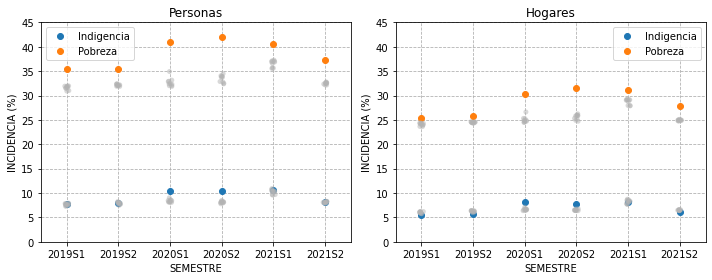

In [30]:
data_ = data.set_index(['SEMESTRE', 'model', 'sample']).stack().reset_index()
data_ = data_.rename(columns = {'level_3': 'Variable', 0: 'pct'})

dataH_ = dataH.set_index(['SEMESTRE', 'model', 'sample']).stack().reset_index()
dataH_ = dataH_.rename(columns = {'level_3': 'Variable', 0: 'pct'})


fig, axs = plt.subplots(1, 2, figsize = (10, 4))

ax = axs[0]
ax.set_title('Personas')
info.plot(marker = 'o', lw = 0, ax = ax)
sns.stripplot(data=data_, x="SEMESTRE", y="pct", color = '.7', ax = ax, alpha = .5, jitter = .04)
ax.set_ylim(0, 45); ax.grid(linestyle = '--'); ax.set_ylabel('INCIDENCIA (%)')

ax = axs[1]
ax.set_title('Hogares')
infoH.plot(marker = 'o', lw = 0, ax = ax)
sns.stripplot(data=dataH_, x="SEMESTRE", y="pct", color = '.7', ax = ax, alpha = .5, jitter = .04)
ax.set_ylim(0, 45); ax.grid(linestyle = '--'); ax.set_ylabel('INCIDENCIA (%)')

plt.tight_layout()
plt.savefig('./../images/comparacion_INDEC.jpg')
plt.show()

### Incerteza en valores de AGLO

In [19]:
out_list = []; out_listH = []

for i in range(n_models):
    models_tag = str(i).zfill(3)

    for j in range(2):
        sample_tag = str(10*j).zfill(3)
        experiment_tag = str(int(models_tag) + int(sample_tag)).zfill(3)

        print(experiment_tag)

        df = pd.read_csv('/media/miglesia/Elements/suite/indice-pobreza-ExactasUBA/data/Pobreza/pobreza_0.01_'+experiment_tag+'.csv')
        df['AGLO_si'] = df['AGLOMERADO'] != 0
        df['Q'] = pd.to_datetime(df['Q'])
        df['SEMESTRE'] = df['Q'].dt.year.astype(str) + 'S'+ np.where(df['Q'].dt.quarter.gt(2),2,1).astype(str)
        
        ### PERSONAS
        table = 100*df.loc[df.AGLO_si == True].groupby(['AGLOMERADO', 'SEMESTRE'])[['Pobreza', 'Indigencia']].mean()
#         display(table.round(4))
        table['model'] = models_tag
        table['sample'] = sample_tag
        
        ### HOGARES
        dfH = df.copy()
        dfH = dfH[['AGLO_si', 'AGLOMERADO', 'SEMESTRE', 'Q', 'HOGAR_REF_ID', 'Pobreza', 'Indigencia']]
        # dfH.drop_duplicates().shape
        dfH = dfH.drop_duplicates()
        tableH = 100*dfH.loc[dfH.AGLO_si == True].groupby(['AGLOMERADO', 'SEMESTRE'])[['Pobreza', 'Indigencia']].mean()
        tableH['model'] = models_tag
        tableH['sample'] = sample_tag

        out_list += [table]
        out_listH += [tableH]

000
010
001
011
002
012
003
013
004
014


In [20]:
aglo_labels = pd.read_csv('./../data/info/aglo_labels.csv')

data = pd.concat(out_list).reset_index().merge(aglo_labels)
dataH = pd.concat(out_listH).reset_index().merge(aglo_labels)

In [22]:
stoch_from_model = data.groupby(['SEMESTRE', 'AGLOMERADO', 'NOMAGLO', 'sample'])['Pobreza', 'Indigencia'].agg(['mean', 'std'])
stoch_from_model = stoch_from_model.groupby(level = [0, 1, 2]).mean()
stoch_from_model.groupby(level = [1, 2]).mean().round(1)

<ipython-input-22-070e7c68f34f>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stoch_from_model = data.groupby(['SEMESTRE', 'AGLOMERADO', 'NOMAGLO', 'sample'])['Pobreza', 'Indigencia'].agg(['mean', 'std'])


Pobreza      Indigencia     
                                 mean  std       mean  std
AGLOMERADO NOMAGLO                                        
2          La Plata              29.2  0.8        7.7  0.5
3          Bahia Blanca          25.5  1.2        6.1  0.6
4          Rosario               32.3  0.8        8.4  0.4
5          Santa Fe              38.0  0.9       11.0  0.6
6          Parana                34.2  1.0        8.5  0.7
7          Posadas               42.3  1.0       12.9  0.8
8          Resistencia           43.7  1.2       12.8  0.8
9          Cdro Rivadavia        26.7  2.5        5.6  0.7
10         Mendoza               35.1  0.8        7.3  0.5
12         Corrientes            40.0  1.1       11.6  0.7
13         Cordoba               33.1  0.8        8.1  0.4
14         Concordia             44.4  1.3       11.2  1.2
15         Formosa               46.6  1.4       14.4  1.0
17         Neuquen               28.0  1.3        5.8  0.5
18         Sgo del Estero        41.8  1.0       10.9  0.6
19         Jujuy                 38.4  1.1        9.8  0.6
20         Rio Gallegos          27.0  1.6        5.0  0.7
22         Catamarca             37.1  1.3        9.8  0.9
23         Salta                 38.7  0.9       10.5  0.7
25         La Rioja              45.5  1.4        9.7  0.9
26         San Luis              41.5  1.1        9.0  0.7
27         San Juan              45.4  1.1       11.1  0.6
29         Tucuman               38.6  0.8       10.6  0.6
30         Santa Rosa            26.4  1.7        6.6  0.8
31         Ushuaia-Rio Grande    22.8  1.9        4.1  0.6
32         CABA                  13.2  0.6        3.4  0.2
33         GBA                   35.9  0.9        9.0  0.5
34         Mar del Plata         27.4  1.0        6.5  0.4
36         Rio Cuarto            31.7  1.2        7.5  0.7
38         San Nicolas           36.5  1.3        9.2  0.8
91         Rawson-Trelew         29.9  1.5        6.6  0.8
93         Viedma-Patagones      28.7  1.8        5.7  0.8